# 9.2 Multi-output and multi-layer models

In the previous notebook, we have seen a simple neural network regressor (Linear regression) and classifier (Logistic regression) that were implemented as a single artificial neuron.

In this notebook we will learn how to build more complex network architectures. We will implement a
* __multi-output single layer perceptron__ to obtain a multi-label linear classification model
* __multi-layer perceptron__ to obtain a non-linear classification model

## Multi-label linear classification
<img src="images/softmax_cropped.png" width = "300" style="float: right;">

A single layer perceptron consists of multiple neurons organised in one layer. These  neurons  share  the  same  input  features,  but  each  of  them  produces a different output. The outputs of the linear layer for each neuron $z_k=\sum_jw_{jk}x_j$ are either passed through the same activation function $f(z)$, or in case of multi-label classification through a shared **softmax** activation function:
$$ \hat{p}_k=\frac{e^z_k}{\sum_{j=1}^Ke^z_{j}}$$

The linear multi-label classification is implemented with a **single linear layer**, with
* the number of **inputs** equal to the number of **features**
* the number of **outputs** equal to the number of **classes**

For example, if we would like to predict no, mild moderate and severe heart failure from EF and GLS, we need two inputs and three outputs.

In [1]:
import torch
from torch import nn
l = nn.Linear(2,3)
print(l)

Linear(in_features=2, out_features=3, bias=True)


The loss will be set to **cross-entropy** using the in-built function `CrossEntropyLoss`. This function combined softmax with cross-entropy loss, so we will not need to implement the activation in our network. For numerical reasons, Pytorch implements log-softmax followed by negative log-likelihood loss in this function.

In [2]:
loss_function = nn.CrossEntropyLoss()

## Exercise 2: Multi-label linear classifier

In this exercise we will implement a multi-label classifier in Pytorch, to predict no, mild moderate and severe heart failure from EF and GLS. Code below loads and plots the data, and converts the data into Pytorch tensors.

Note, that the input features are required to be of type `float`, while output labels need to be of type `long`.

In [3]:
# only do this if you work on Google Colab
# run the cell
# then upload file 'heart_failure_data_complete.csv'

#from google.colab import files
#files.upload()

X:  torch.Size([120, 2])
y:  torch.Size([120])


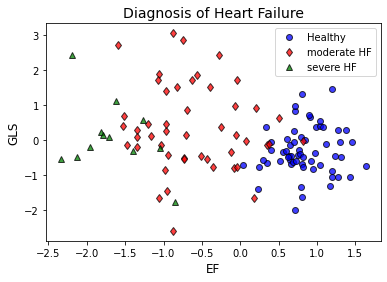

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('heart_failure_data_complete.csv')
data = df.to_numpy()
X = data[:,[1,2]]
X = StandardScaler().fit_transform(X)
y = data[:,0]

def PlotData(X,y,fontsize=12):
    plt.plot(X[y==0,0],X[y==0,1],'bo',alpha=0.75,markeredgecolor='k',label = 'Healthy')
    plt.plot(X[y==1,0],X[y==1,1],'rd',alpha=0.75,markeredgecolor='k',label = 'moderate HF')
    plt.plot(X[y==2,0],X[y==2,1],'g^',alpha=0.75,markeredgecolor='k',label = 'severe HF')
    plt.title('Diagnosis of Heart Failure', fontsize = fontsize+2)
    plt.xlabel('EF', fontsize = fontsize)
    plt.ylabel('GLS', fontsize = fontsize)
    plt.legend(fontsize = fontsize-2)

PlotData(X,y)

# convert numpy array to tensor in shape of input size
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()
print('X: ', X.shape)
print('y: ', y.shape)

Below is the function to plot the classification result. Run the code.

In [5]:
def PlotClassification(net,X,y,fontsize=12):

    # Create an 1D array of samples for each feature
    x1 = np.linspace(-2.5, 2, 1000) 
    x2 = np.linspace(-3, 3.5, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 
    
    # NEW: convert numpy to torch
    Feature_space = torch.from_numpy(Feature_space).float()
    # NEW: Predict output scores for the whole feature space    
    output_scores = net(Feature_space)
    # NEW: Take maximum to get the labels
    _,y_pred=torch.max(output_scores, 1)
    # NEW: Convert to numpy
    y_pred = y_pred.numpy()
    
    # Resahpe to 2D
    y_pred = y_pred.reshape(x1.shape)
    # Plot using contourf
    plt.contourf(x1, x2, y_pred, cmap = 'summer')
    
    # Plot data
    PlotData(X,y,fontsize)

### Train test split
**Task 2.1:** First, split the data into training set and test set. For this, we will use scikit-learn `train_test_split`. Note that this function works on Pytorch tensors the same way as on numpy arrays. Use 33% of the data for testing. Note the types of the split dataset.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print('Test features type:', X_test.type())
print('Test labels type:', y_test.type())
print('Test labels:', y_test)

Test features type: torch.FloatTensor
Test labels type: torch.LongTensor
Test labels: tensor([0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 0, 2, 0, 0, 2, 0])


### Create and train the network
**Task 2.2:** Fill in the code below to create and train multi-label classification model in Pytorch. Make sure that the network is trained using only training data

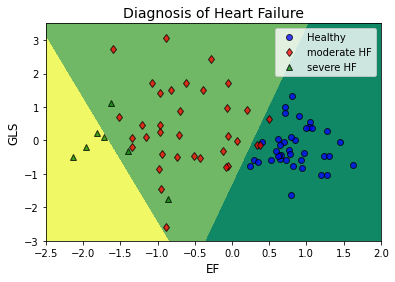

In [7]:
# network architecture
class MultiLabelClassifier(nn.Module):
    def __init__(self):
        super(MultiLabelClassifier, self).__init__()
        self.layer = nn.Linear(2, 3)

    def forward(self, x):
        x = self.layer(x) 
        return x

# create model    
net = MultiLabelClassifier()

# loss
loss_function = nn.CrossEntropyLoss()

# optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)

# train for 500 epochs
epochs = 500
for i in range(epochs):
    optimizer.zero_grad() 
    prediction = net(X_train) 
    loss = loss_function(prediction, y_train) 
    loss.backward()       
    optimizer.step() 

# Plot result
PlotClassification(net,X_train,y_train)

### Evaluate training accuracy

We will now show how we can predict the labels on the test set using this network. Because softmax and cross-entropy loss are combined, for each sample the network will return three outputs of the linear layer $z_0,z_1,z_2$ that correspond to the three classes. These outputs are referred to as **logits**. Let's test that on an individual feature vector $x=(0,0)$ that we create:

In [8]:
# create a feature vector of correct shape and type
x = torch.tensor((0,0)).reshape(1,2).float()
# predict using forward pass
z = net(x)
# print logits
print('Logits: ', z)

Logits:  tensor([[-0.0154,  1.3971, -2.3245]], grad_fn=<AddmmBackward>)


To find the label for this datapoint, we need to find which class returned the largest logit:

In [9]:
y = torch.argmax(z, dim=1)
print('Predicted label: ', y)

Predicted label:  tensor([1])


**Task 2.3:** Fill in the code to predict the labels for the training set

In [10]:
# forward pass
pred=net(X_train)
# find maximum
y_pred_train = torch.argmax(pred, dim=1)
print(y_pred_train)

tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 1, 0, 2, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1])


Pytorch does not offer functions for calculating performance measures, by the can use `accuracy_score` from scikit-learn.

In [11]:
from sklearn.metrics import accuracy_score
print('Training accuracy: ', accuracy_score(y_train, y_pred_train))

Training accuracy:  0.925


### Evaluate on test set

**Task 2.3:** To evaluate accuracy on the test set, implement the following:
* predict the logits for the test set by running a forward pass through the network
* convert logits to label
* calculate test accuracy score
* plot the classification result for the test set

Test accuracy:  0.825


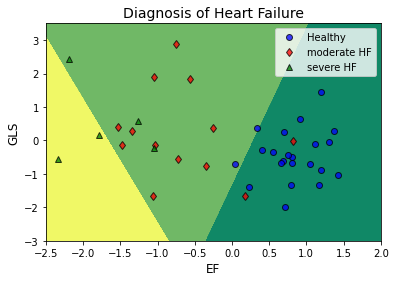

In [12]:
# forward pass
pred=net(X_test)

# find maximum
y_pred_test = torch.argmax(pred, dim=1)

# calculate accuracy
print('Test accuracy: ', accuracy_score(y_test, y_pred_test))

# plot
PlotClassification(net,X_test,y_test)

<img src="images/MLP_binary_classifier_cropped.png" width = "350" style="float: right;">

## Multi-layer perceptron for non-linear classification

The flexibility of the neural networks comes from combining many artificial neurons into a single machine learning model organized in multiple layers. Linear layers of neurons with multiple outputs can be stacked one after another resulting in a **multi layer perceptron** model. If we add non-linear activation functions between the layers, we will be able to create flexible non-linear models. Networks consisting of several linear layers are also called **fully connected deep neural networks**. 

The image on the right illustrates a two-layer network that we will create to build a **non-linear binary classifier**. It has two input features. The first linear layer has two inputs and six outputs. Multiple outputs will give us flexibility to fit a highly non-linear decision boundary. The six outputs of the first layer will become inputs of the second layer, which has only one output. After the first layer, we will have **ReLU** activation, to introduce non-linearity to the network. After the second layer we have **Sigmoid** activation to build a binary classifier.

## Exercise 3: Non-linear classifier

In this exercise we are going to fit a multi-layer perceptron to a simulated dataset with two co-centric circles. Run the cell below to create and display the dataset.

X:  torch.Size([500, 2])
y:  torch.Size([500, 1])


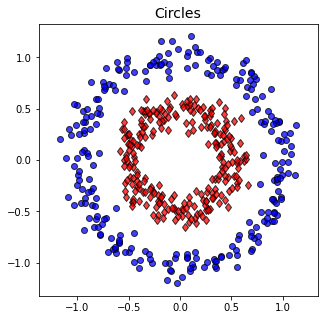

In [13]:
from sklearn.datasets import make_circles

X,y = make_circles(n_samples=500,factor=0.5, noise=0.08)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y.reshape(-1,1)).float()
print('X: ', X.shape)
print('y: ', y.shape)

def PlotData2(X,y):
    y=y.flatten()
    plt.plot(X[y==0,0],X[y==0,1],'bo',alpha=0.75,markeredgecolor='k')
    plt.plot(X[y==1,0],X[y==1,1],'rd',alpha=0.75,markeredgecolor='k')
    plt.axis('equal')
    plt.title('Circles', fontsize = 14)
    #plt.axis('off')

plt.figure(figsize = (5,5))
PlotData2(X,y)

We need a slightly different function to plot the classification result, run the code below.

In [14]:
def PlotClassification2(net,X,y):

    # Create an 1D array of samples for each feature
    a = 0.2
    x1 = np.linspace(X[:,0].min()-a, X[:,0].max()+a, 1000) 
    x2 = np.linspace(X[:,1].min()-a, X[:,1].max()+a, 1000).T # note the transpose
    # Creates 2D arrays that hold the coordinates in 2D feature space
    x1, x2 = np.meshgrid(x1, x2) 
    # Flatten x1 and x2 to 1D vector and concatenate into a feature matrix
    Feature_space = np.c_[x1.ravel(), x2.ravel()] 
    
    # NEW: convert numpy to torch
    Feature_space = torch.from_numpy(Feature_space).float()
    # NEW: Predict output scores for the whole feature space    
    output_scores = net(Feature_space)
    # NEW: Threshold output scores
    y_pred = (output_scores>0.5).long()
    
    # Resahpe to 2D
    y_pred = y_pred.reshape(x1.shape)
    # Plot using contourf
    plt.contourf(x1, x2, y_pred, cmap = 'summer')
    
    # Plot data
    PlotData2(X,y)
    plt.axis('off')

**Task 3.1:** In the cell below is a working code to fit a single-layer perceptron to the dataset. Run the code. What do you observe? Is the classifier suitable for the dataset?

**Answer:** This is a linear classifier that cannot fit this highly non-linear dataset

**Task 3.2:** Modify the network architecture so that it can fit this non-linear dataset. In function `__init__` implement 
* linear `layer1` with two inputs and 6 outputs
* `ReLU` activation
* linear `layer2` with 6 inputs and one output
* `Sigmoid` activation
Then modify the `forward` function accordingly. Run the cell to train and display the multi-layer perceptron classifier.

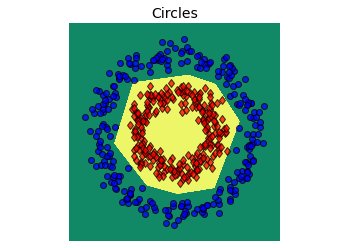

In [15]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.layer1 = nn.Linear(2, 6)
        self.relu = nn.ReLU() 
        self.layer2 = nn.Linear(6, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x
    
def train(net, X, y):
    loss_function = nn.BCELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.2, momentum=0.75)
    epochs = 500
    for i in range(epochs):
        optimizer.zero_grad() 
        prediction = net(X) 
        loss = loss_function(prediction, y) 
        loss.backward()       
        optimizer.step()   
    return net

net2 = MLPClassifier()
train(net2,X,y)
PlotClassification2(net2,X,y)

**Task 3.3 (optional):** Simulate an additional dataset to create an independent test set. Calculate accuracy on this dataset.

In [16]:
# simulate test set
X_test, y_test = make_circles(n_samples=500,factor=0.5, noise=0.08)

# convert to tensors
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.reshape(-1,1)).float()
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_test:  torch.Size([500, 2])
y_test:  torch.Size([500, 1])


In [17]:
# predict probabilities for class 1
pred = net2(X_test)

# threshold to create labels
y_pred_test = (pred>=0.5).long()

# calculate accuracy
accuracy_score(y_test,y_pred_test)

1.0